## Problema

NeuralWorks en su constante búsqueda por realizar proyectos entretenidos ha decidido explorar los patrones de
movimientos de las personas para lograr una ciudad libre de autos. Hemos conseguido la data de diferentes fuentes
para entender el origen-destino de las personas para poder entender cómo eficientar el transporte público,
locaciones de puntos estratégicos, turnos entre personas con viajes similares, etc.

Como Data Engineer en este proyecto te ha tocado apoyar con la **creación de turnos entre personas con viajes
similares**. Para esto hemos adjuntado un CSV con una muestra de la data de los viajes realizados en 3 regiones. La
Data Scientist del equipo necesita tu ayuda para poder hacer un análisis profundo de los datos y construir un
modelo de machine learning. Te ha pedido cumplir con los siguientes requisitos:

1. Procesos automatizados para ingerir y almacenar los datos bajo demanda

    a. Los viajes que son similares en términos de origen, destino y hora del día deben agruparse. Describa el enfoque que utilizó para agregar viajes similares.


2. Un servicio que es capaz de proporcionar la siguiente funcionalidad: 

    a. Devuelve el promedio semanal de la cantidad de viajes para un área definida por un bounding box y la región.

    b. Informar sobre el estado de la ingesta de datos sin utilizar una solución de polling.


3. La solución debe ser escalable a 100 millones de entradas. Se recomienda simplificar los datos mediante un modelo de datos. Agregue pruebas de que la solución es escalable.


4. La solución debe estar escrita en Python usando una base de datos SQL


5. Puntos de bonificación si incluye su solución en contenedores y si dibuja cómo configuraría la aplicación en GCP

In [42]:
import pickle

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

Se leen los datos y se formatean según su tipo de dato.

In [2]:
df = pd.read_csv("trips.csv")
df["origin_coord"] = gpd.GeoSeries.from_wkt(df["origin_coord"])
df["destination_coord"] = gpd.GeoSeries.from_wkt(df["destination_coord"])
df["datetime"] = pd.to_datetime(df["datetime"])

In [3]:
df

,region,origin_coord,destination_coord,datetime,datasource
0,Prague,POINT (14.49738 50.00137),POINT (14.43109 50.04053),2018-05-28 09:03:40,funny_car
1,Turin,POINT (7.67284 44.99571),POINT (7.72037 45.06782),2018-05-21 02:54:04,baba_car
2,Prague,POINT (14.32427 50.00002),POINT (14.47768 50.09340),2018-05-13 08:52:25,cheap_mobile
3,Turin,POINT (7.54151 45.09161),POINT (7.74529 45.02629),2018-05-06 09:49:16,bad_diesel_vehicles
4,Turin,POINT (7.61408 45.13433),POINT (7.52750 45.03335),2018-05-23 12:45:54,pt_search_app
...,...,...,...,...,...
95,Prague,POINT (14.33562 50.05977),POINT (14.45302 50.06961),2018-05-03 18:56:45,cheap_mobile
96,Hamburg,POINT (9.99671 53.52204),POINT (10.17431 53.51796),2018-05-23 12:43:17,baba_car
97,Prague,POINT (14.40976 50.03779),POINT (14.59895 50.05472),2018-05-12 08:13:09,cheap_mobile
98,Hamburg,POINT (10.08339 53.59661),POINT (10.17914 53.60909),2018-05-22 10:39:49,baba_car


El problema claramente corresponde a un problema de aprendizaje no supervisado, donde se deben agrupar viajes similares **SIN UTILIZAR LA REGIÓN**. Para esto se crea un dataset seǵun las características del enunciado: origen, destino y hora del día. Por otro lado, se calcula la distancia de los viajes.

In [4]:
features = pd.DataFrame(
    {
        "num_hour": df["datetime"].apply(lambda x: int(x.strftime("%H"))),
        "x_orig": df["origin_coord"].apply(lambda x: x.x),
        "y_orig": df["origin_coord"].apply(lambda x: x.y),
        "x_dest": df["destination_coord"].apply(lambda x: x.x),
        "y_dest": df["destination_coord"].apply(lambda x: x.y),
        "distance": df.apply(
            lambda x: x["origin_coord"].distance(x["destination_coord"]), axis=1
        ),
    }
)

In [11]:
features

,num_hour,x_orig,y_orig,x_dest,y_dest,distance,cluster
0,9,14.497379,50.001369,14.431095,50.040529,0.076988,2
1,2,7.672838,44.995711,7.720369,45.067824,0.086368,4
2,8,14.324273,50.000021,14.477679,50.093398,0.179590,2
3,9,7.541509,45.091605,7.745287,45.026286,0.213990,1
4,12,7.614078,45.134331,7.527497,45.033351,0.133016,1
...,...,...,...,...,...,...,...
95,18,14.335623,50.059773,14.453024,50.069610,0.117812,0
96,12,9.996715,53.522037,10.174314,53.517965,0.177646,5
97,8,14.409755,50.037792,14.598955,50.054721,0.189955,2
98,10,10.083389,53.596613,10.179140,53.609093,0.096561,3


Los viajes que se aprecian, son claremente inter-región, es decir, no hay viajes de una región a otra, son solo dentros de la misma región.

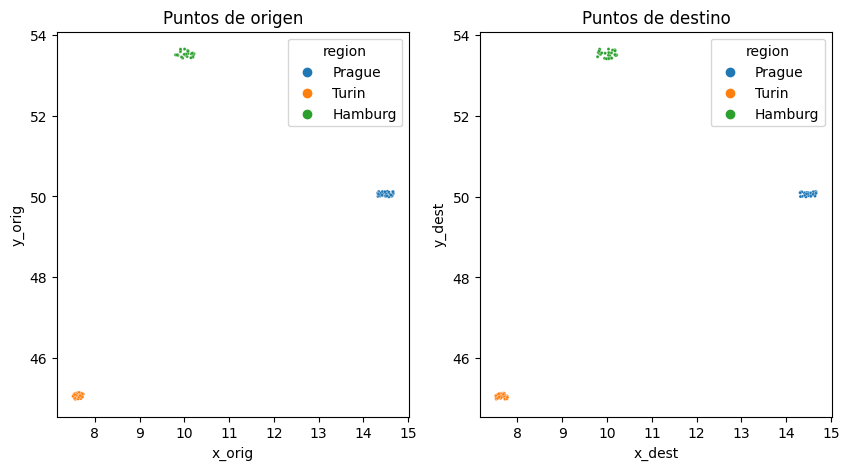

In [13]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(data=features, x="x_orig", y="y_orig", hue=df["region"], ax=ax[0], s=5)
sns.scatterplot(data=features, x="x_dest", y="y_dest", hue=df["region"], ax=ax[1], s=5)

ax[0].set_title("Puntos de origen")
ax[1].set_title("Puntos de destino")
plt.show()

Al parecer los viajes de Praga suelen ser cercanos y los de Hamburgo más distantes.

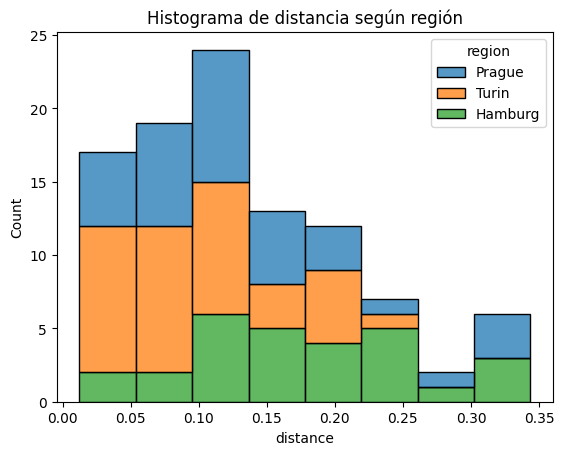

In [34]:
ax = sns.histplot(data=features, x="distance", hue=df["region"], multiple="stack")
ax.set_title("Histograma de distancia según región")
plt.show()

Para afinar de alguna medida el algoritmo a usar, escalo los datos con una normalización estándar.

In [6]:
scaler = StandardScaler()
x = scaler.fit_transform(features)

Para escoger el número de clúster a utilizar, se utiliza el método del codo. Este nos indica un k=[5, 6]. Ocuparé 6, básicamente porque son 3 regiones conocidas y es probable que haya 2 tipos de viajes en cada una (si, es algo de trampa jaja).

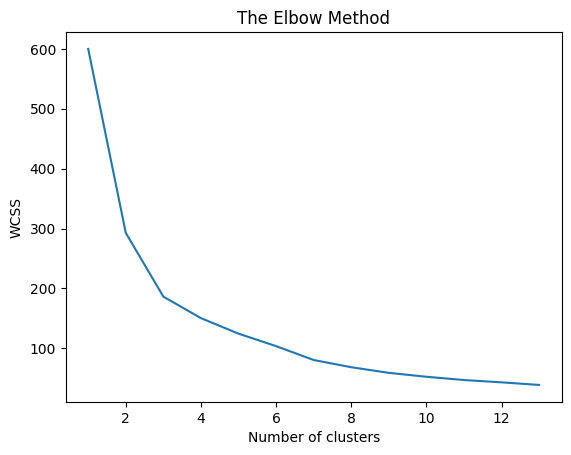

In [7]:
wcss = []
for i in range(1, 14):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=1313)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 14), wcss)
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [28]:
kmeans = KMeans(n_clusters=6, init="k-means++", random_state=5)
y_kmeans = kmeans.fit_predict(x)
features["cluster"] = y_kmeans

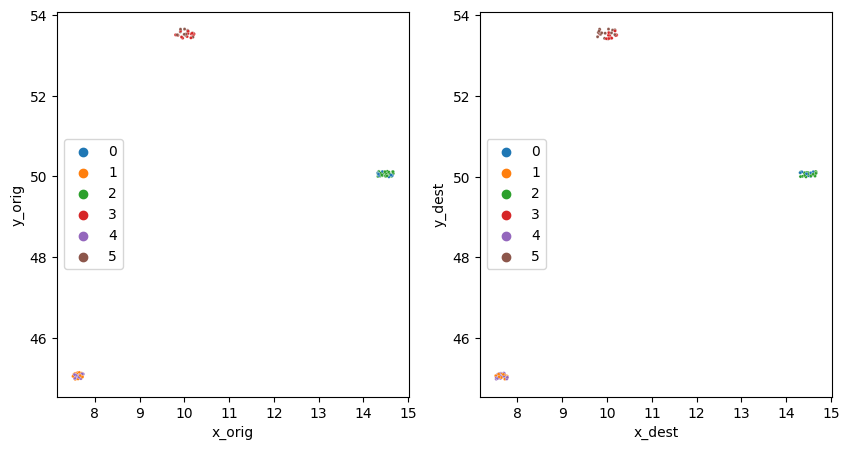

In [29]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(
    data=features, x="x_orig", y="y_orig", hue="cluster", ax=ax[0], s=5, palette="tab10"
)
sns.scatterplot(
    data=features, x="x_dest", y="y_dest", hue="cluster", ax=ax[1], s=5, palette="tab10"
)

ax[0].legend(loc="center left")
ax[1].legend(loc="center left")

plt.show()

El histograma según grupo, tiene un comportamiento esperable. Por ejemplo:
- Los grupos 0 y 2 están en la región de Prague.
- Los grupos 1 y 4 están en la región de Turin.
- Los grupo 3 y 5 estan 

In [45]:
sol = pd.DataFrame({"region": df["region"], "cluster": features["cluster"]})
sol.groupby("cluster").apply(lambda x: np.unique(x["region"], return_counts=True))

cluster
0      ([Prague], [9])
1      ([Turin], [19])
2     ([Prague], [25])
3    ([Hamburg], [14])
4      ([Turin], [19])
5    ([Hamburg], [14])
dtype: object

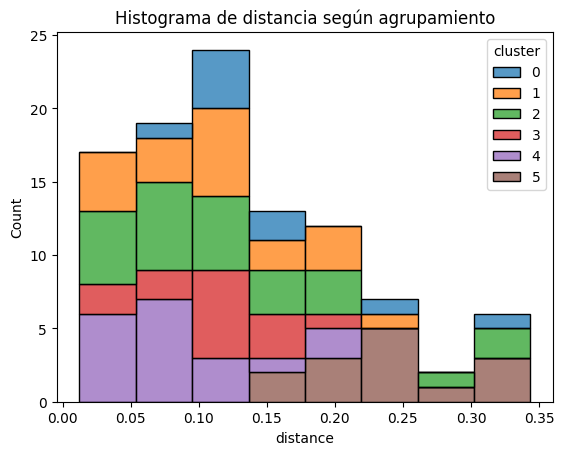

In [35]:
ax = sns.histplot(
    data=features, x="distance", hue="cluster", multiple="stack", palette="tab10"
)
ax.set_title("Histograma de distancia según agrupamiento")
plt.show()

In [10]:
with open("models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("models/kmeans.pkl", "wb") as f:
    pickle.dump(kmeans, f)